/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_1258/1783105856.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Diabeto indikatorius', group_keys=False).apply(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and 

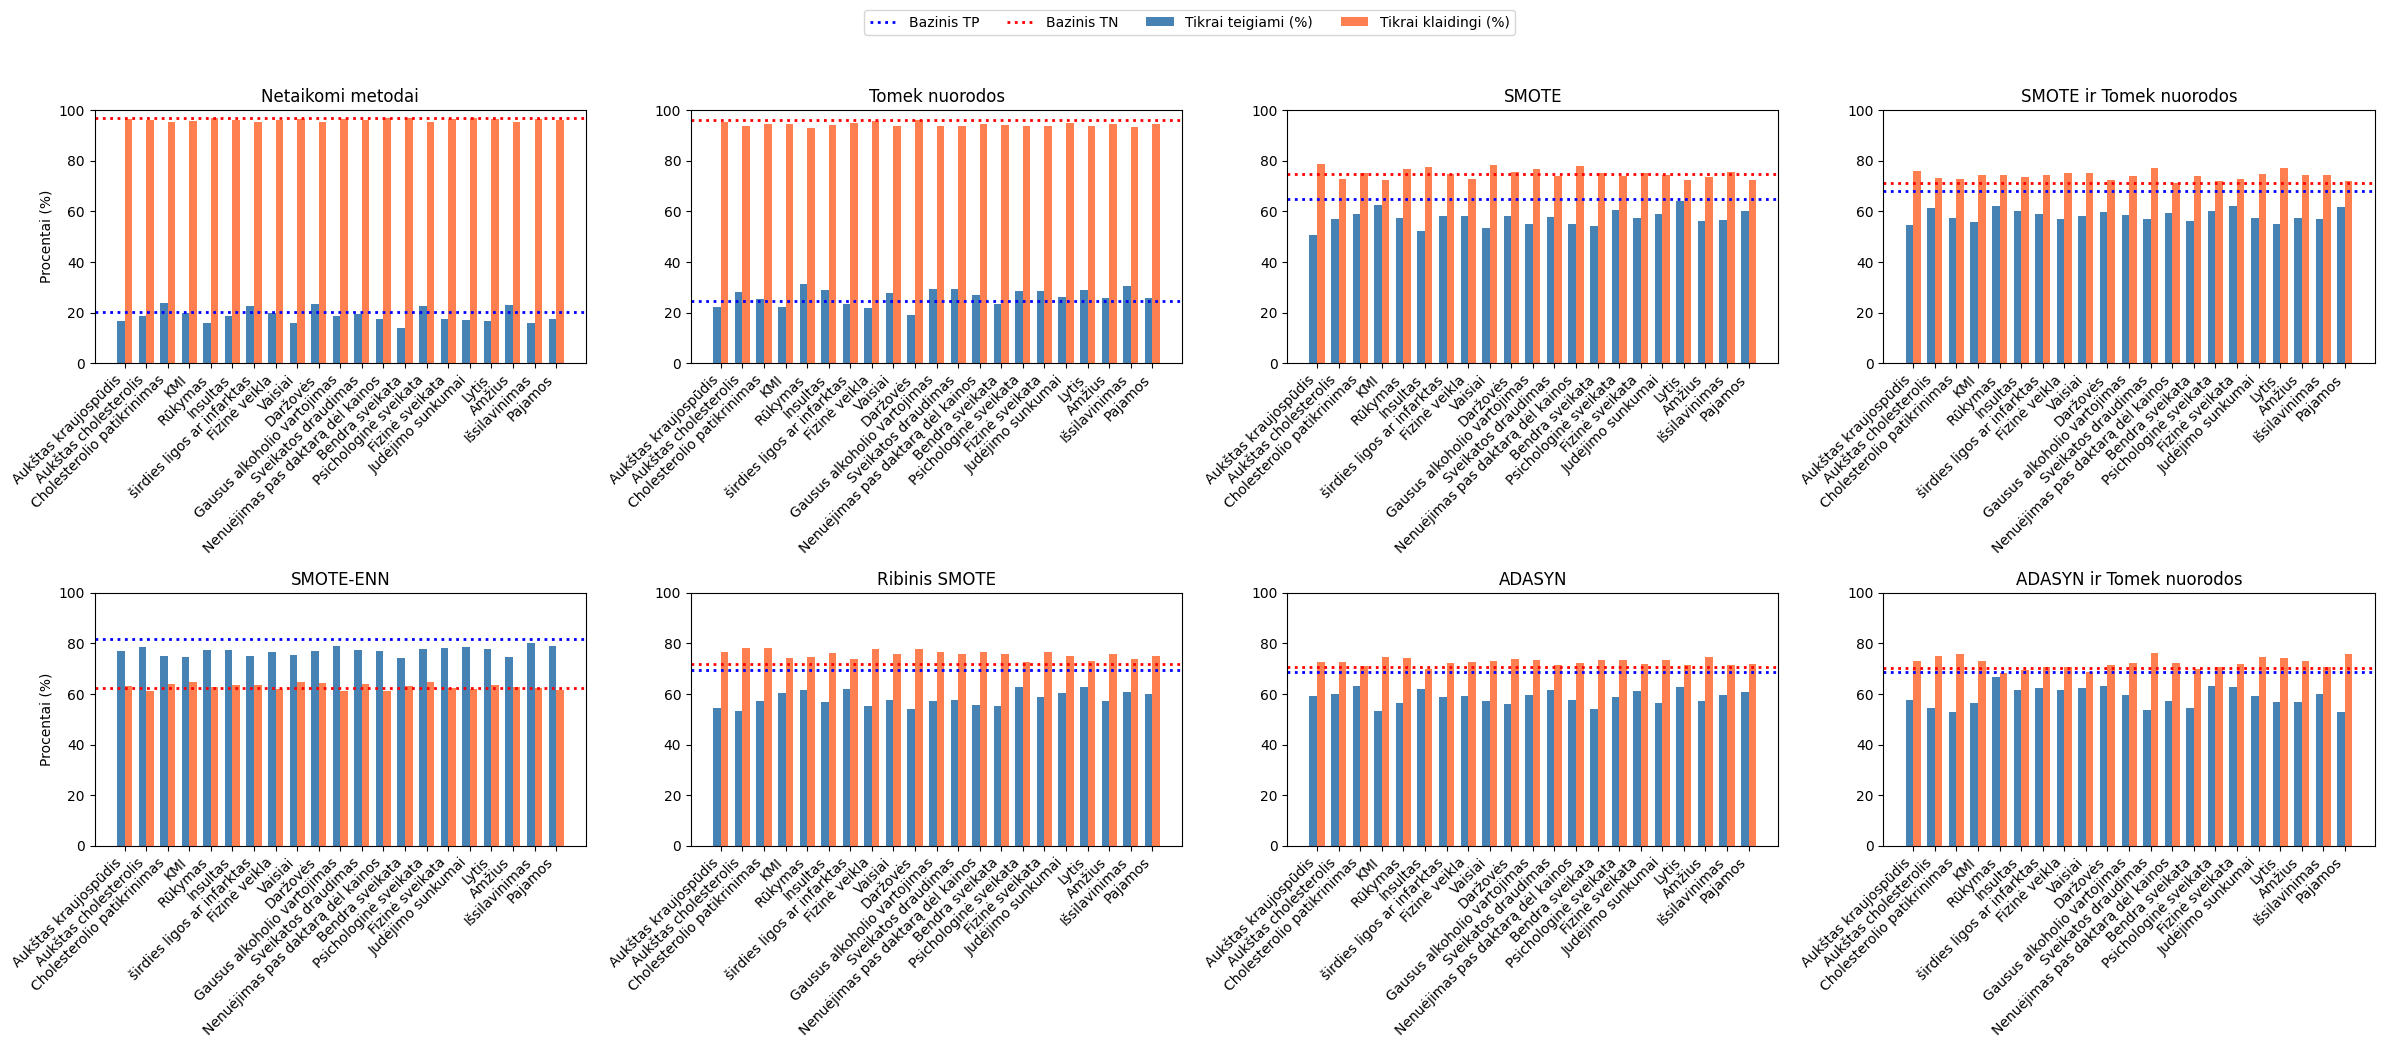

In [ ]:
# MLP daugumos ir mažumos klasių klasifikavimo priklausomybė nuo duomenų požymių 
# bei naudojamų skirtingų metodų
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import TomekLinks


resampling_methods = {
    'Netaikomi metodai': None,
    'Tomek nuorodos': 'tomek',
    'SMOTE': SMOTE(sampling_strategy=0.99, random_state=7),
    'SMOTE ir Tomek nuorodos': SMOTETomek(sampling_strategy=0.99, random_state=7),
    'SMOTE-ENN': SMOTEENN(sampling_strategy=0.99, random_state=7),
    'Ribinis SMOTE': BorderlineSMOTE(sampling_strategy=0.99, random_state=7),
    'ADASYN': ADASYN(sampling_strategy=0.99, random_state=7),
    'ADASYN ir Tomek nuorodos': 'adasyn_tomek'
}

baseline_values = {
    'Netaikomi metodai': (20.32, 97.06),
    'SMOTE': (65.12, 74.92),
    'ADASYN': (68.51, 70.62),
    'Tomek nuorodos': (24.73, 96.18),
    'SMOTE ir Tomek nuorodos': (68.12, 71.36),
    'ADASYN ir Tomek nuorodos': (68.61, 70.35),
    'Ribinis SMOTE': (69.29, 71.87),
    'SMOTE-ENN': (81.81, 62.28)
}


df = pd.read_csv('cdc_diabetes_data.csv', encoding='utf-8-sig')
df.drop(columns=['ID'], inplace=True)

X = df.drop(columns=['Diabeto indikatorius'])
y = df['Diabeto indikatorius']


fig, axs = plt.subplots(2, 4, figsize=(24, 10))
axs = axs.flatten()

for idx, (name, sampler) in enumerate(resampling_methods.items()):
    tp_percentages = []
    tn_percentages = []
    x_labels = []

    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    scaler = StandardScaler()

    for feature in X.columns:
        X_mod = X.drop(columns=[feature])
        X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.3, random_state=7, stratify=y)

        if sampler == 'tomek':
            tl = TomekLinks()
            X_train_res, y_train_res = tl.fit_resample(X_train, y_train)
        elif sampler == 'adasyn_tomek':
            adasyn = ADASYN(sampling_strategy=0.99, random_state=7)
            tl = TomekLinks()
            X_temp, y_temp = adasyn.fit_resample(X_train, y_train)
            X_train_res, y_train_res = tl.fit_resample(X_temp, y_temp)
        elif sampler is None:
            X_train_res, y_train_res = X_train.copy(), y_train.copy()
        else:
            X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

        X_train_scaled = scaler.fit_transform(X_train_res)
        X_test_scaled = scaler.transform(X_test)

        mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=7)
        mlp.fit(X_train_scaled, y_train_res)
        y_pred = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, y_pred)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_percentages.append(cm_pct[1, 1])
        tn_percentages.append(cm_pct[0, 0])
        x_labels.append(feature)

    ax = axs[idx]
    width = 0.35
    indices = np.arange(len(x_labels))

    ax.bar(indices, tp_percentages, width, label='Tikrai teigiami (%)', color='steelblue')
    ax.bar(indices + width, tn_percentages, width, label='Tikrai klaidingi (%)', color='coral')

    baseline_tp, baseline_tn = baseline_values[name]
    ax.axhline(y=baseline_tp, color='blue', linestyle=':', linewidth=2, label='Bazinis TP')
    ax.axhline(y=baseline_tn, color='red', linestyle=':', linewidth=2, label='Bazinis TN')

    ax.set_title(name)
    ax.set_xticks(indices + width / 2)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    if idx % 4 == 0:
        ax.set_ylabel('Procentai (%)')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("diabetes_removed.png", dpi=300, bbox_inches='tight')
plt.show()
